In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import plotly.graph_objects as go 
import plotly.express as px
import pandas as pd

In [2]:
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
pcs = pd.read_csv('data/pcs.csv')

In [4]:
pcs.head()

,survey_year,program_category,region_served,age_group,sex,transgender,sexual_orientation,hispanic_ethnicity,race,living_situation,household_composition,preferred_language,veteran_status,employment_status,number_of_hours_worked_each_week,education_status,special_education_services,mental_illness,intellectual_disability,autism_spectrum,other_developmental_disability,alcohol_related_disorder,drug_substance_disorder,mobility_impairment_disorder,hearing_visual_impairment,hyperlipidemia,high_blood_pressure,diabetes,obesity,heart_attack,stroke,other_cardiac,pulmonary_asthma,alzheimer_or_dementia,kidney_disease,liver_disease,endocrine_condition,neurological_condition,traumatic_brain_injury,joint_disease,cancer,no_chronic_med_condition,unknown_chronic_med_condition,smokes,received_smoking_medication,received_smoking_counseling,serious_mental_illness,principal_diagnosis_class,additional_diagnosis_class,ssi_cash_assistance,ssdi_cash_assistance,veterans_disability_benefits,veterans_cash_assistance,public_assistance_cash_program,other_cash_benefits,medicaid_and_medicare_insurance,no_insurance,unknown_insurance_coverage,medicaid_insurance,medicaid_managed_insurance,medicare_insurance,private_insurance,child_health_plus_insurance,family_health_plus_insurance,other_insurance,criminal_justice_status,three_digit_residence_zip_code,other_chronic_med_condition
0,2013,SUPPORT,WESTERN REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,UNKNOWN,ENGLISH,NO,UNKNOWN EMPLOYMENT STATUS,NOT APPLICABLE,UNKNOWN,NOT APPLICABLE,YES,NO,UNKNOWN,NO,UNKNOWN,UNKNOWN,NO,NO,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,YES,NO,NO,NO,YES,UNKNOWN/DEFERRED,UNKNOWN/DEFERRED,UNKNOWN,UNKNOWN,NO,NO,NO,UNKNOWN,UNKNOWN,UNKNOWN,YES,UNKNOWN,NOT APPLICABLE,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,UNKNOWN,999,UNKNOWN
1,2013,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",OTHER,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ASIAN AND PACIFIC ISLAND,NO,EMPLOYED,35 HOURS OR MORE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,YES,NO,NO,NO,NO,NO,NO,YES,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NOT APPLICABLE,NO,YES,NO,NO,NO,NO,112,UNKNOWN
2,2013,OUTPATIENT,WESTERN REGION,ADULT,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",BLACK ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,"UNEMPLOYED, LOOKING FOR WORK",NOT APPLICABLE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,UNKNOWN,NO,NO,NO,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,NO,146,UNKNOWN
3,2013,OUTPATIENT,NEW YORK CITY REGION,ADULT,FEMALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,NOT APPLICABLE,MIDDLE SCHOOL TO HIGH SCHOOL,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,NO,NO,YES,MENTAL ILLNESS,MENTAL ILLNESS,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,NOT APPLICABLE,YES,NO,NO,NO,NO,NO,103,UNKNOWN
4,2013,OUTPATIENT,CENTRAL NY REGION,CHILD,MALE,"NO, NOT TRANSGENDER",STRAIGHT OR HETEROSEXUAL,"NO, NOT HISPANIC/LATINO",WHITE ONLY,PRIVATE RESIDENCE,COHABITATES WITH OTHERS,ENGLISH,NO,NOT IN LABOR FORCE:UNEMPLOYED AND NOT LOOKING ...,NOT APPLICABLE,PRE-K TO FIFTH GRADE,NO,YES,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,NO,YES,MENTAL ILLNESS,UNKNOWN/DEFERRED,NO,NO,NO,NO,NO,NO,NO,NO,NO,YES,NO,NO,NO,YES,NO,NO,NO,137,UNKNOWN


Lets check out how many people on this sruvey has mental illness

In [5]:
pcs['mental_illness'].value_counts(normalize=True)

YES        0.949670
NO         0.040709
UNKNOWN    0.009621
Name: mental_illness, dtype: float64

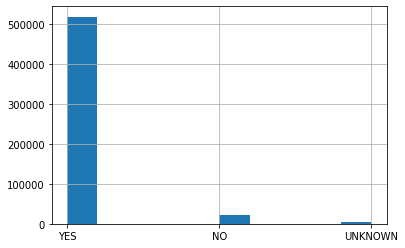

In [6]:
pcs['mental_illness'].hist()

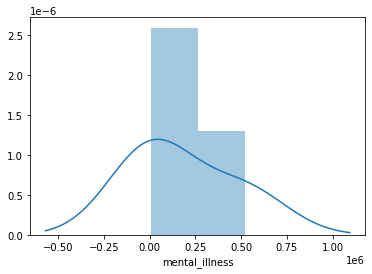

In [ ]:
sns.countplot(x="living_situation", palette="ch:.25", data=pcs, )

The overwheming majority huh......

In [7]:
pcs['age_group'].value_counts(normalize=True)

ADULT      0.797600
CHILD      0.202241
UNKNOWN    0.000159
Name: age_group, dtype: float64

In [8]:
pd.crosstab(pcs['mental_illness'], pcs['age_group'], normalize=True, margins=True)

age_group,ADULT,CHILD,UNKNOWN,All
mental_illness,,,,
NO,0.026610,0.014083,0.000016,0.040709
UNKNOWN,0.005896,0.003700,0.000026,0.009621
YES,0.765094,0.184458,0.000117,0.949670
All,0.797600,0.202241,0.000159,1.000000


Children account for approximately 18 percent of mental illness patients

In [9]:
pd.crosstab(pcs['mental_illness'], pcs['sex'], normalize=True, margins=True)

sex,FEMALE,MALE,UNKNOWN,All
mental_illness,,,,
NO,0.019737,0.019098,0.001874,0.040709
UNKNOWN,0.004794,0.004686,0.000141,0.009621
YES,0.475524,0.469441,0.004705,0.949670
All,0.500055,0.493226,0.006719,1.000000


In [10]:
pd.crosstab(pcs['mental_illness'], pcs['race'], normalize=True, margins=True)

race,BLACK ONLY,MULTI-RACIAL,OTHER,UNKNOWN RACE,WHITE ONLY,All
mental_illness,,,,,,
NO,0.008699,0.001047,0.007158,0.002974,0.020831,0.040709
UNKNOWN,0.002018,0.000143,0.001061,0.001427,0.004972,0.009621
YES,0.248779,0.029720,0.161166,0.026591,0.483412,0.949670
All,0.259497,0.030910,0.169386,0.030992,0.509215,1.000000


In [11]:
pd.crosstab(pcs['mental_illness'], pcs['serious_mental_illness'], normalize=True, margins=True)

serious_mental_illness,NO,UNKNOWN,YES,All
mental_illness,,,,
NO,0.033301,0.001005,0.006403,0.040709
UNKNOWN,0.006297,0.002077,0.001248,0.009621
YES,0.110549,0.003630,0.835491,0.949670
All,0.150147,0.006712,0.843141,1.000000


Strangely enough, 84.3 percent of respondants have a serious mental illness, along with 94.9 percent who havve a mental illness 

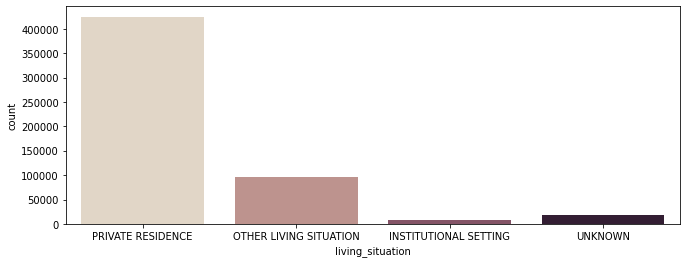

In [15]:
f, axes = plt.subplots( sharey=True, figsize=(11, 4))
sns.countplot(x="living_situation", palette="ch:.25", data=pcs, )

In [16]:
pcs['living_situation'].value_counts(normalize=True)

PRIVATE RESIDENCE         0.776853
OTHER LIVING SITUATION    0.176370
UNKNOWN                   0.032784
INSTITUTIONAL SETTING     0.013993
Name: living_situation, dtype: float64

Most live in a private residence, but the second largest feature is other. With little info on that, I become curious as to the true state of 20% of the respondants

In [31]:
pcs['three_digit_residence_zip_code'].value_counts(normalize=True)

112    0.143071
104    0.108854
100    0.087152
117    0.042738
113    0.041494
142    0.037130
114    0.035517
999    0.035347
146    0.029386
888    0.028396
105    0.024910
115    0.021689
103    0.020161
125    0.018174
140    0.018103
148    0.017133
130    0.015678
132    0.015607
109    0.015537
120    0.013427
107    0.012536
145    0.012264
144    0.012112
116    0.011945
136    0.011830
134    0.010430
129    0.010381
121    0.009962
147    0.009910
128    0.009437
124    0.008353
119    0.007806
122    0.007744
111    0.007080
141    0.006937
131    0.006877
135    0.006545
123    0.006130
138    0.006128
126    0.005978
149    0.005945
110    0.005848
127    0.005810
133    0.005277
143    0.005274
139    0.005131
106    0.005113
137    0.004555
108    0.004015
118    0.001576
101    0.001568
Name: three_digit_residence_zip_code, dtype: float64

In [25]:
 l = pcs['three_digit_residence_zip_code'].value_counts(normalize=True)

In [30]:
l.head(9).sum()

0.5606889030397517

Almost 25% of the group are accounted for with two zipcodes. With a wikipedia search, we see that comprises Brooklyn and The Bronx. Bring in income data for the region

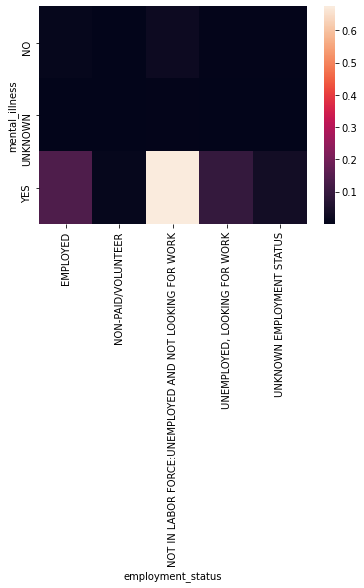

In [21]:
sns.heatmap(
    pd.crosstab(
        [pcs.mental_illness], 
        [pcs.employment_status], 
        normalize=True))